<span style="color:gray">
Copyright &copy; 2020-2021 by Fraunhofer-Gesellschaft. All rights reserved.<br>
Fraunhofer Institute for Integrated Circuits IIS, Division Engineering of Adaptive Systems EAS<br>
Münchner Straße 16, 01187 Dresden, Germany
</span>

---

## ESB - Energy Saving by Blockchain

Eurostars – EXP 00119832 / EUS-2019113348

---

## Prediction of Energy Consumption for Variable Customer Portfolios Including Aleatoric Uncertainty Estimation

*Oliver Mey, André Schneider, Olaf Enge-Rosenblatt, Yesnier Bravo, Pit Stenzel*

The notebook is part of a paper submission contributed to the **10th International Conference on Power Science and Engineering (ICPSE 2021)** will be held on Oct. 21-23, 2021 in Yildiz Technical University, Istanbul, Turkey.

---

# A1: Data Exploration

This notebook loads the available datasets and explains the content and how the data is structured. Furthermore, a few sample plots illustrate the data.

---

<span style="color:gray">
Version 0.3.7 (September 12, 2021)<br>
Authors: Oliver Mey, André Schneider (Fraunhofer IIS)<br>
</span>    

In [1]:
import warnings, logging, os
warnings.filterwarnings('ignore')
logging.disable(logging.WARNING)
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

In [2]:
import os
import joblib
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import holidays as hd
import seaborn as sns
import tensorflow as tf

%matplotlib inline
sns.set(rc={'figure.figsize':(16, 6)})

### Configuration

In [3]:
path = '..'
categories = ['consumption', 'weather', 'profiles']
files = [path + '/data/' + '20201015_' + name + '.xlsx' for name in categories]
timezone = 'Europe/Madrid'

### Function Definitions

In [4]:
def fix_DST(data):
    data = data[~data.index.duplicated(keep='first')]
    data = data.resample('H').ffill()
    return data

def crop(data):
    hour_index = data.index.hour
    t0 = data[hour_index==0].head(1).index
    tn = data[hour_index==23].tail(1).index
    data.drop(data.loc[data.index < t0[0]].index, inplace=True)
    data.drop(data.loc[data.index > tn[0]].index, inplace=True)
    return

### Loading Consumption Data

In [5]:
consumptions = pd.read_excel(files[categories.index('consumption')], parse_dates=[0], index_col=0)
consumptions.columns = pd.DataFrame(consumptions.columns, columns=['customer']).index
consumptions.index.name = 'time'
fix_DST(consumptions)
crop(consumptions)

The *consumptions* dataframe contains **499** columns. A column represents a single *customer* with a customer ID in the range of *0..498*. Each row in the dataframe contains the *consumption* values for a certain timestamp within the measurement period of about one year (Jan 01 - Dec 31, 2019). The time series were recorded with an hourly resolution. This means the dataframe contains **8760** rows (365 day x 24 hours).

In [6]:
consumptions

,0,1,2,3,4,5,6,7,8,9,...,489,490,491,492,493,494,495,496,497,498
time,,,,,,,,,,,,,,,,,,,,,
2019-01-01 00:00:00,0.039,0.384,0.986,0.706,0.304,0.073,3.262,3.0,0.645,1.279,...,0.431,0.100,0.010,0.258,0.009,0.488,0.810,0.309,0.366,0.290
2019-01-01 01:00:00,0.269,0.051,0.846,2.210,0.673,0.047,3.252,4.0,0.746,0.851,...,0.447,0.025,0.009,0.232,0.009,0.447,0.753,0.381,0.308,0.369
2019-01-01 02:00:00,0.331,0.049,0.970,1.797,0.310,0.058,3.043,4.0,0.678,0.789,...,0.439,0.025,0.009,0.260,0.009,0.508,0.092,0.193,0.137,0.292
2019-01-01 03:00:00,0.093,0.049,0.803,1.010,0.545,0.059,2.960,4.0,0.644,0.637,...,0.913,0.023,0.009,0.252,0.009,0.511,0.032,0.124,0.201,0.358
2019-01-01 04:00:00,0.116,0.050,1.303,0.660,0.410,0.072,3.054,3.0,0.130,0.262,...,1.256,0.024,0.009,0.278,0.009,0.510,0.081,0.081,0.223,0.380
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-31 19:00:00,0.009,0.052,0.773,0.138,0.579,0.322,3.851,2.0,0.236,0.303,...,0.039,1.308,0.009,1.761,0.011,2.036,0.249,0.223,0.245,0.573
2019-12-31 20:00:00,0.009,0.410,0.738,0.076,0.229,1.810,3.767,1.0,0.053,5.062,...,0.036,0.298,0.027,0.375,0.011,2.022,0.058,0.363,0.354,0.644
2019-12-31 21:00:00,0.010,0.058,0.748,0.072,0.107,1.478,3.342,1.0,0.108,2.140,...,0.261,0.120,0.052,0.463,0.010,1.107,0.011,0.573,0.393,0.635


In [7]:
consumptions.describe()

,0,1,2,3,4,5,6,7,8,9,...,489,490,491,492,493,494,495,496,497,498
count,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,...,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000
mean,0.283303,0.263868,1.750522,0.275184,0.277605,0.218282,2.393745,4.763017,0.227725,0.602395,...,0.269928,0.170956,0.053764,0.803501,0.169984,0.809818,0.112445,0.238333,0.413233,0.460819
std,0.436013,0.345561,0.781109,0.332088,0.387865,0.248986,1.648356,8.413416,0.310379,0.783770,...,0.363086,0.308614,0.048554,0.824487,0.673361,0.573233,0.112697,0.146475,0.371725,0.127375
min,0.000000,0.041000,0.000000,0.007000,0.008000,0.040000,0.012000,0.000000,0.041000,0.118000,...,0.000000,0.016000,0.008000,0.172000,0.007000,0.160000,0.000000,0.076000,0.079000,0.214000
25%,0.000000,0.062000,1.143750,0.089000,0.091000,0.079000,1.133750,2.000000,0.061000,0.234000,...,0.054000,0.023000,0.010000,0.317750,0.026000,0.422000,0.038000,0.106000,0.149000,0.359000
50%,0.113000,0.094000,1.611000,0.128000,0.105000,0.128000,2.478500,3.000000,0.140000,0.326000,...,0.100000,0.024000,0.053000,0.456000,0.054000,0.592000,0.071000,0.206500,0.295000,0.467000
75%,0.277000,0.387250,2.112250,0.332000,0.266000,0.268000,3.495000,4.000000,0.245000,0.606000,...,0.335250,0.122000,0.084000,1.035250,0.056000,0.976000,0.151000,0.343000,0.473000,0.551000
max,3.067000,3.192000,4.899000,3.547000,3.342000,2.487000,8.994000,107.000000,4.185000,8.691000,...,3.149000,2.115000,1.193000,7.760000,17.114000,4.769000,1.046000,1.040000,2.030000,1.309000


### Example Plot for Consumption of Customer #20

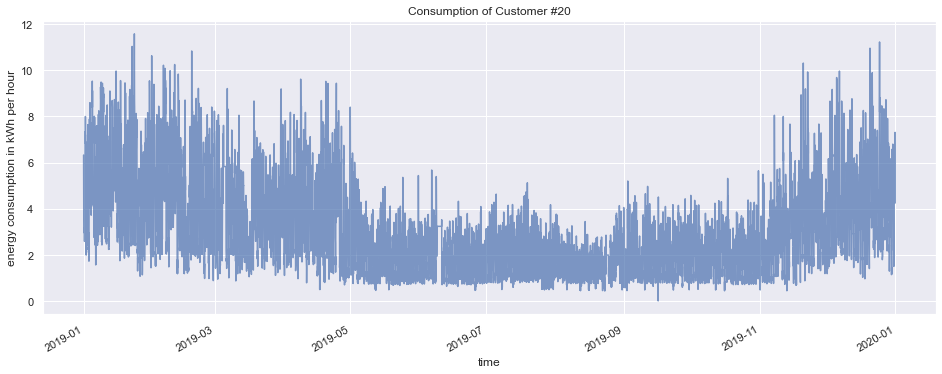

In [8]:
customer = 20
_ = consumptions.loc[:, customer].plot(color='b', alpha=0.7, ylabel='energy consumption in kWh per hour',
                                 title='Consumption of Customer #' + str(customer))

### Loading Weather Data

In [9]:
weather = pd.read_excel(files[categories.index('weather')], parse_dates=[0], index_col=0)
weather.columns = consumptions.columns
weather.index.name = 'time'
fix_DST(weather)
crop(weather)

The *weather* dataframe contains **499** columns. A column represents a single *customer* with a customer ID in the range of *0..498*. Each row in the dataframe contains the *weather* data (outside temperature of the customer's region) for a certain timestamp within the measurement period of about one year (Jan 01 - Dec 30, 2019). The time series were recorded with an hourly resolution. This means the dataframe contains **8760** rows (365 day x 24 hours).

In [10]:
weather

,0,1,2,3,4,5,6,7,8,9,...,489,490,491,492,493,494,495,496,497,498
time,,,,,,,,,,,,,,,,,,,,,
2019-01-01 00:00:00,10.31,10.35,1.65,1.70,11.53,10.76,10.57,0.43,1.66,10.49,...,10.40,9.53,9.94,3.19,3.14,3.20,2.63,1.51,1.51,1.51
2019-01-01 01:00:00,10.34,10.38,1.33,1.37,11.78,10.79,10.61,0.17,1.33,10.73,...,10.65,10.21,10.63,3.70,3.65,3.71,2.08,1.21,1.21,1.21
2019-01-01 02:00:00,10.36,10.40,1.01,1.05,12.03,10.82,10.64,-0.09,1.01,10.98,...,10.90,10.88,11.33,4.22,4.17,4.23,1.53,0.91,0.91,0.91
2019-01-01 03:00:00,10.39,10.43,0.69,0.73,12.28,10.84,10.68,-0.34,0.69,11.23,...,11.14,11.56,12.02,4.74,4.69,4.75,0.99,0.60,0.60,0.60
2019-01-01 04:00:00,10.27,10.31,0.47,0.51,12.13,10.73,10.57,-0.62,0.48,11.06,...,10.97,11.33,11.79,4.47,4.42,4.48,0.76,0.38,0.38,0.38
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-31 19:00:00,17.99,18.03,14.88,14.94,17.51,18.15,18.08,12.33,14.89,16.91,...,16.84,16.00,16.10,11.62,11.57,11.63,8.99,13.20,13.20,13.20
2019-12-31 20:00:00,17.87,17.91,14.69,14.74,17.32,18.10,18.01,12.45,14.70,16.62,...,16.54,15.84,16.01,11.03,10.98,11.04,8.11,13.01,13.01,13.01
2019-12-31 21:00:00,17.74,17.78,14.50,14.55,17.14,18.05,17.94,12.57,14.50,16.33,...,16.25,15.68,15.93,10.44,10.39,10.45,7.22,12.82,12.82,12.82


In [11]:
weather.describe()

,0,1,2,3,4,5,6,7,8,9,...,489,490,491,492,493,494,495,496,497,498
count,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,...,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000
mean,18.677202,18.695718,19.025963,19.074118,18.640517,18.575288,18.575945,16.410300,19.031903,18.483400,...,18.428421,18.076798,18.121936,18.029516,18.013313,18.032670,16.298357,17.600161,17.600161,17.600161
std,4.170381,4.156910,8.816318,8.815930,4.049639,3.999922,4.043740,8.096028,8.816432,4.382668,...,4.401210,4.164785,4.071509,7.831887,7.862237,7.825749,8.248807,8.541373,8.541373,8.541373
min,8.340000,8.380000,-1.220000,-1.180000,8.540000,8.550000,8.460000,-2.600000,-1.220000,7.560000,...,7.460000,7.090000,7.390000,1.730000,1.680000,1.740000,-1.930000,-1.410000,-1.410000,-1.410000
25%,15.477500,15.500000,12.287500,12.337500,15.520000,15.520000,15.470000,10.097500,12.290000,15.050000,...,14.970000,14.890000,15.000000,11.937500,11.890000,11.940000,9.917500,10.947500,10.947500,10.947500
50%,18.600000,18.630000,18.630000,18.680000,18.580000,18.525000,18.510000,15.830000,18.640000,18.380000,...,18.335000,18.315000,18.330000,17.150000,17.125000,17.160000,15.570000,17.150000,17.150000,17.150000
75%,21.680000,21.692500,25.290000,25.330000,21.640000,21.470000,21.500000,22.042500,25.292500,21.800000,...,21.760000,21.380000,21.330000,23.270000,23.262500,23.262500,22.180000,23.762500,23.762500,23.762500
max,31.440000,31.420000,42.070000,42.120000,29.450000,30.900000,31.010000,38.570000,42.080000,29.650000,...,29.650000,29.680000,29.840000,43.050000,43.100000,43.040000,39.010000,39.710000,39.710000,39.710000


### Example Plot for Weather Data (Outside Temperature) of Customer #20

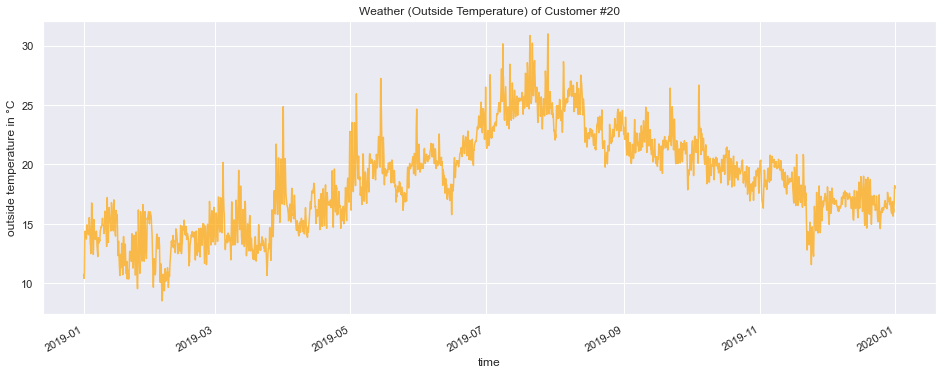

In [12]:
customer = 20
_ = weather.loc[:, customer].plot(color='orange', alpha=0.7, ylabel='outside temperature in °C',
                                 title='Weather (Outside Temperature) of Customer #' + str(customer))

### Loading Customer Profiles

In [13]:
customers = pd.read_excel(files[categories.index('profiles')])
customers.columns = ['customer', 'profile']

The *customers* dataframe contains **499** rows. A row represents a single *customer* with a customer ID in the range of *0..498*. For each customer an anonymized identifier as well as a *profile* are stored.

In [14]:
customers

,customer,profile
0,5d6fcd1cf44b0324bc6b7254,Actividades de los hogares como productores de...
1,5d6fcd1cf44b0324bc6b7257,Actividades de los hogares como productores de...
2,5d6fcd1cf44b0324bc6b725a,Comercio al por menor de frutas y hortalizas e...
3,5d6fcd1cf44b0324bc6b725d,Actividades de los hogares como productores de...
4,5d6fcd1df44b0324bc6b7260,Actividades de los hogares como productores de...
...,...,...
494,5d6fcd7df44b0324bc6b79f7,Actividades de los hogares como productores de...
495,5d6fcd7df44b0324bc6b79fd,Actividades de los hogares como productores de...
496,5d6fcd7ef44b0324bc6b7a00,Otras actividades asociativas n.c.o.p.
497,5d6fcd7ef44b0324bc6b7a02,Otras actividades asociativas n.c.o.p.


### Extracting Profiles 

In [15]:
profiles = pd.DataFrame(customers['profile'].unique(), columns=['profile'])

There are **68** different customer profiles. The dataframe *profiles* contains all these profile descriptions.

In [16]:
profiles

,profile
0,Actividades de los hogares como productores de...
1,Comercio al por menor de frutas y hortalizas e...
2,Fabricación de galletas y productos de panader...
3,"Actividades de contabilidad, teneduría de libr..."
4,Restaurantes y puestos de comidas
...,...
63,Actividades generales de la Administración Púb...
64,"Inversión colectiva, fondos y entidades financ..."
65,Construcción de edificios
66,"Actividades de fotocopiado, preparación de doc..."


### Calculating Synthetic Weather Forecast Data

In [17]:
weather_forecast = weather.copy()
weather_forecast.index = weather_forecast.index + pd.Timedelta(days=1)

As there were no weather forecast data available, the forecast has been calculated synthetically. The dataframe *weather_forecast* contains **499** columns for all customers. Each row in the dataframe contains the synthetically predicted outside temperature for the day ahead. Since the weather time series were recorded with an hourly resolution, the dataframe contains 8760 rows (365 day x 24 hours, Jan 02, 2019 - Jan 01, 2020).

In [18]:
weather_forecast

,0,1,2,3,4,5,6,7,8,9,...,489,490,491,492,493,494,495,496,497,498
time,,,,,,,,,,,,,,,,,,,,,
2019-01-02 00:00:00,10.31,10.35,1.65,1.70,11.53,10.76,10.57,0.43,1.66,10.49,...,10.40,9.53,9.94,3.19,3.14,3.20,2.63,1.51,1.51,1.51
2019-01-02 01:00:00,10.34,10.38,1.33,1.37,11.78,10.79,10.61,0.17,1.33,10.73,...,10.65,10.21,10.63,3.70,3.65,3.71,2.08,1.21,1.21,1.21
2019-01-02 02:00:00,10.36,10.40,1.01,1.05,12.03,10.82,10.64,-0.09,1.01,10.98,...,10.90,10.88,11.33,4.22,4.17,4.23,1.53,0.91,0.91,0.91
2019-01-02 03:00:00,10.39,10.43,0.69,0.73,12.28,10.84,10.68,-0.34,0.69,11.23,...,11.14,11.56,12.02,4.74,4.69,4.75,0.99,0.60,0.60,0.60
2019-01-02 04:00:00,10.27,10.31,0.47,0.51,12.13,10.73,10.57,-0.62,0.48,11.06,...,10.97,11.33,11.79,4.47,4.42,4.48,0.76,0.38,0.38,0.38
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-01-01 19:00:00,17.99,18.03,14.88,14.94,17.51,18.15,18.08,12.33,14.89,16.91,...,16.84,16.00,16.10,11.62,11.57,11.63,8.99,13.20,13.20,13.20
2020-01-01 20:00:00,17.87,17.91,14.69,14.74,17.32,18.10,18.01,12.45,14.70,16.62,...,16.54,15.84,16.01,11.03,10.98,11.04,8.11,13.01,13.01,13.01
2020-01-01 21:00:00,17.74,17.78,14.50,14.55,17.14,18.05,17.94,12.57,14.50,16.33,...,16.25,15.68,15.93,10.44,10.39,10.45,7.22,12.82,12.82,12.82


### Loading Holidays

In [19]:
holidays = hd.ES(years=list(range(2010, 2021)), prov="MD")

Since the energy consumption behavior depends on weekly seasonalities like *working day* or public *holiday*, a list of all public holidays is needed for feature extraction.

In [20]:
holidays

{datetime.date(2016, 1, 1): 'Año nuevo',
 datetime.date(2016, 1, 6): 'Epifanía del Señor',
 datetime.date(2016, 3, 24): 'Jueves Santo',
 datetime.date(2016, 3, 25): 'Viernes Santo',
 datetime.date(2016, 5, 2): 'Día de Comunidad de Madrid, Día del Trabajador (Trasladado)',
 datetime.date(2016, 8, 15): 'Asunción de la Virgen',
 datetime.date(2016, 10, 12): 'Día de la Hispanidad',
 datetime.date(2016, 11, 1): 'Todos los Santos',
 datetime.date(2016, 12, 6): 'Día de la Constitución Española',
 datetime.date(2016, 12, 8): 'La Inmaculada Concepción',
 datetime.date(2016, 12, 26): 'Navidad (Trasladado)',
 datetime.date(2017, 1, 2): 'Año nuevo (Trasladado)',
 datetime.date(2017, 1, 6): 'Epifanía del Señor',
 datetime.date(2017, 4, 13): 'Jueves Santo',
 datetime.date(2017, 4, 14): 'Viernes Santo',
 datetime.date(2017, 5, 1): 'Día del Trabajador',
 datetime.date(2017, 8, 15): 'Asunción de la Virgen',
 datetime.date(2017, 10, 12): 'Día de la Hispanidad',
 datetime.date(2017, 11, 1): 'Todos los Sa

### Calculating Day Categories

In [21]:
days = pd.DataFrame(pd.to_datetime(consumptions.index.date), index=consumptions.index, columns=['date'])
days['day_of_week'] = list(days.index.dayofweek)
days['day_of_month'] = list(days.index.day)
days['month'] = list(days.index.month)
days['day_category'] = days['day_of_week'].replace({0:0,1:1,2:1,3:1,4:2,5:3,6:4})
days.loc[days['date'].apply(lambda d: d in holidays), 'day_category'] = 4
days = days.groupby(['date']).first()

The dataframe *days* contains additional information for characterizing a certain date (day). For each day within the measurement period the day of the week, the day within the month, the month as well as the day category was calculated. The used day categories are *'Monday'* (0), *'Tuesday-Thursday'* (1), *'Friday'* (2), *'Saturday'* (3), and *'Sunday or Holiday'* (4).

In [22]:
days

,day_of_week,day_of_month,month,day_category
date,,,,
2019-01-01,1,1,1,4
2019-01-02,2,2,1,1
2019-01-03,3,3,1,1
2019-01-04,4,4,1,2
2019-01-05,5,5,1,3
...,...,...,...,...
2019-12-27,4,27,12,2
2019-12-28,5,28,12,3
2019-12-29,6,29,12,4


### Calculating the Daily Mean for the Consumptions

In [23]:
consumptions_daily_mean = pd.DataFrame(consumptions.groupby(consumptions.index.date).mean(), index=days.index)

The dataframe *consumptions_daily_mean* contains the daily mean values for the energy consumption of all customers. This means the table has **499** columns (customers) and **365** rows (days within the measurement period).

In [24]:
consumptions_daily_mean

,0,1,2,3,4,5,6,7,8,9,...,489,490,491,492,493,494,495,496,497,498
date,,,,,,,,,,,,,,,,,,,,,
2019-01-01,0.107208,0.119875,0.932625,0.432833,0.580750,0.155292,3.258292,3.083333,0.310667,0.663500,...,0.484083,0.090833,0.017417,0.257833,0.008958,0.876458,0.107708,0.249500,0.280333,0.341458
2019-01-02,0.145333,0.112542,1.224708,0.394375,0.312583,0.201458,3.240833,3.125000,0.359667,1.056167,...,0.535167,0.207208,0.017833,1.256625,0.008792,1.031042,0.043375,0.256208,0.329125,0.364458
2019-01-03,0.453875,0.297750,1.159792,0.532375,0.418292,0.300583,3.323167,2.791667,0.331083,0.842958,...,0.588833,0.226792,0.018042,1.335750,0.008917,1.105083,0.041417,0.277292,0.325250,0.367042
2019-01-04,0.640625,0.288208,1.158750,0.387958,0.459500,0.205417,3.309583,2.875000,0.280542,1.194917,...,0.486542,0.215167,0.017917,1.038750,0.008875,1.100333,0.038833,0.317458,0.329500,0.371917
2019-01-05,0.482958,0.285708,1.099417,0.519792,0.191208,0.213208,3.298625,2.833333,0.221875,0.951708,...,0.376167,0.086333,0.017625,0.543000,0.363250,1.001625,0.038625,0.276875,0.325792,0.366250
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-27,0.000000,0.114250,1.130208,0.275958,0.220958,0.129042,3.240458,2.859417,0.347042,0.844292,...,0.387542,0.271125,0.021042,1.155583,0.599708,0.865417,0.040750,0.292458,0.287458,0.511625
2019-12-28,0.000000,0.115958,1.087667,0.316417,0.478667,0.103792,3.336417,2.691667,0.261583,0.447042,...,0.349333,0.045125,0.020500,0.597792,1.556708,0.638792,0.038958,0.213125,0.235708,0.498042
2019-12-29,0.262000,0.116167,0.928208,0.262750,0.444292,0.148417,3.481667,2.900000,0.404083,0.786333,...,0.342167,0.045042,0.020583,0.402208,0.281792,0.736917,0.038917,0.210375,0.200708,0.500333


### Example Plot for Daily Mean Consumption of Customer #20

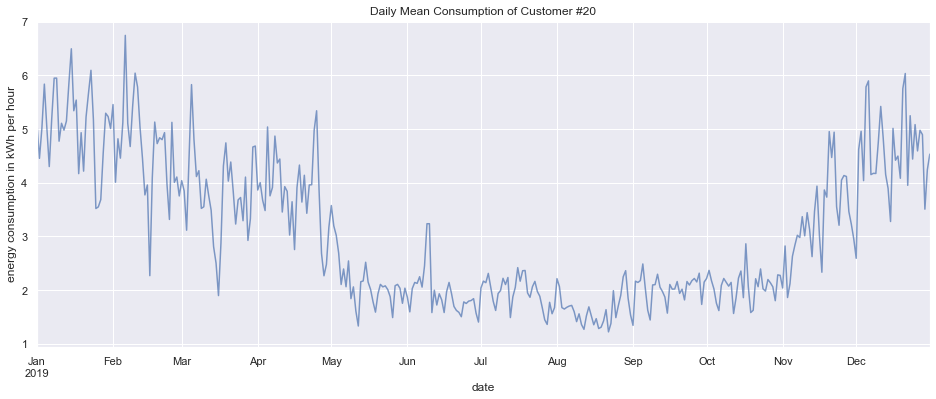

In [25]:
customer = 20
_ = consumptions_daily_mean.loc[:, customer].plot(color='b', alpha=0.7, 
                                                  ylabel='energy consumption in kWh per hour',
                                                  title='Daily Mean Consumption of Customer #' + str(customer))

### Calculating the Daily Mean for the Weather Data

In [26]:
weather_daily_mean = pd.DataFrame(weather.groupby(weather.index.date).mean(), index=days.index)

The dataframe *weather_daily_mean* contains the daily mean values for the weather data (outside temperature) of all customers. This means the table contains **499** columns (customers) and **365** rows (days within the measurement period).

In [27]:
weather_daily_mean

,0,1,2,3,4,5,6,7,8,9,...,489,490,491,492,493,494,495,496,497,498
date,,,,,,,,,,,,,,,,,,,,,
2019-01-01,12.328750,12.363750,5.349583,5.397500,13.213750,12.522083,12.431667,4.043750,5.355417,12.523750,...,12.446667,12.350417,12.591667,8.065833,8.027917,8.072917,4.481250,4.748333,4.748333,4.748333
2019-01-02,14.049583,14.085417,5.789167,5.838750,14.077083,14.242500,14.152083,5.395417,5.795833,13.386667,...,13.310000,13.039167,13.280417,9.103750,9.065417,9.110417,4.233750,5.606667,5.606667,5.606667
2019-01-03,14.383333,14.418333,6.513750,6.562083,14.542500,14.576667,14.485833,5.731250,6.519583,13.852917,...,13.775000,13.766250,14.007500,9.659583,9.622917,9.667917,5.296667,6.423750,6.423750,6.423750
2019-01-04,14.302917,14.338333,7.785417,7.833750,14.669583,14.497083,14.405833,7.046250,7.792500,13.979167,...,13.902500,13.527083,13.769583,9.515417,9.477500,9.522500,5.637917,7.262500,7.262500,7.262500
2019-01-05,13.712500,13.747083,7.265000,7.313750,13.882917,13.905833,13.815000,7.292500,7.271250,13.191250,...,13.115833,13.099583,13.341250,9.204167,9.166667,9.211667,4.648333,6.455833,6.455833,6.455833
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-27,16.589583,16.623333,12.034167,12.082917,16.086250,16.692500,16.649167,11.165417,12.040417,15.467083,...,15.393750,15.867083,16.108750,12.208750,12.175417,12.215417,9.508750,10.398333,10.398333,10.398333
2019-12-28,16.762917,16.797500,13.096250,13.143750,16.247083,16.866667,16.822083,11.322917,13.101250,15.627083,...,15.554167,16.672500,16.915000,12.948333,12.915000,12.955000,10.972500,11.366250,11.366250,11.366250
2019-12-29,16.808333,16.842500,13.534583,13.583750,16.498333,16.912500,16.867083,11.932917,13.541250,15.879583,...,15.805417,14.752083,14.994583,11.788750,11.755417,11.795417,8.668750,11.740833,11.740833,11.740833


### Example Plot for Daily Mean of Weather Data of Customer #20

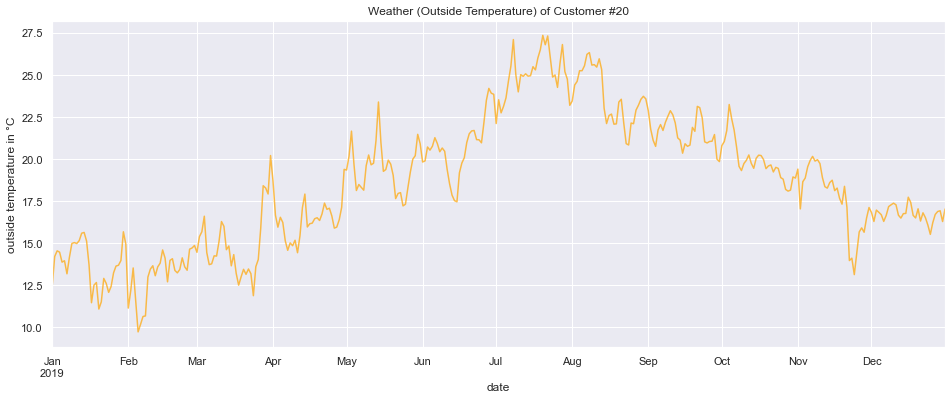

In [28]:
customer = 20
_ = weather_daily_mean.loc[:, customer].plot(color='orange', alpha=0.7, ylabel='outside temperature in °C',
                                 title='Weather (Outside Temperature) of Customer #' + str(customer))